# Modelo SIR con Animación en Python

El modelo epidemiológico **SIR** divide la población en tres compartimentos:

- $S(t)$: Susceptibles  
- $I(t)$: Infectados  
- $R(t)$: Recuperados/Removidos  

Las ecuaciones diferenciales son:

$$
\frac{dS}{dt} = -\beta \frac{S I}{N}, \quad
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I, \quad
\frac{dR}{dt} = \gamma I
$$

Donde:
- $N = S + I + R$ es la población total (constante).  
- $\beta$ es la tasa de transmisión.  
- $\gamma$ es la tasa de recuperación.  
- $R_0 = \frac{\beta}{\gamma}$ es el número reproductivo básico.  


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from ipywidgets import interact
from scipy.integrate import solve_ivp


# Parámetros del modelo

In [18]:
N = 1000        # Población total
t = 100         #Transmisibilidad
k = 2           #Contactos de individuo infectado
b = k*t          
beta = b/N     # Tasa de transmisión
gamma = 0.1     # Tasa de recuperación
D = 1/gamma     # Duración promedio de la infección


# Condiciones iniciales

In [19]:
I0 = 1          # Infectados iniciales
R0 = 0          # Recuperados iniciales
S0 = N - I0 - R0  # Susceptibles iniciales

# Tiempo de simulación

In [20]:
t_max = 200
dt = 0.5   # Paso más grande para que la animación sea más rápida
t = np.linspace(0, t_max, int(t_max/dt))
step = 5

# Modelo SIR


In [21]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# Metodos numericos para resolver el sistema


In [22]:
# Euler simple
def euler(N, beta, gamma, S0, I0, R0, t, dt):
    S, I, R = [S0], [I0], [R0]
    for i in range(1, len(t)):
        dSdt, dIdt, dRdt = deriv((S[-1], I[-1], R[-1]), t[i], N, beta, gamma)
        S.append(S[-1] + dSdt*dt)
        I.append(I[-1] + dIdt*dt)
        R.append(R[-1] + dRdt*dt)
    return np.array(S), np.array(I), np.array(R)

# Runge-Kutta de orden 4 (RK4)
def rk4(N, beta, gamma, S0, I0, R0, t, dt):
    S, I, R = [S0], [I0], [R0]
    for i in range(1, len(t)):
        Si, Ii, Ri = S[-1], I[-1], R[-1]
        ti = t[i-1]
        dS1, dI1, dR1 = deriv((Si, Ii, Ri), ti, N, beta, gamma)
        dS2, dI2, dR2 = deriv((Si + dS1*dt/2, Ii + dI1*dt/2, Ri + dR1*dt/2), ti+dt/2, N, beta, gamma)
        dS3, dI3, dR3 = deriv((Si + dS2*dt/2, Ii + dI2*dt/2, Ri + dR2*dt/2), ti+dt/2, N, beta, gamma)
        dS4, dI4, dR4 = deriv((Si + dS3*dt, Ii + dI3*dt, Ri + dR3*dt), ti+dt, N, beta, gamma)
        S_next = Si + (dt/6)*(dS1 + 2*dS2 + 2*dS3 + dS4)
        I_next = Ii + (dt/6)*(dI1 + 2*dI2 + 2*dI3 + dI4)
        R_next = Ri + (dt/6)*(dR1 + 2*dR2 + 2*dR3 + dR4)
        S.append(S_next); I.append(I_next); R.append(R_next)
    return np.array(S), np.array(I), np.array(R)

# SciPy solve_ivp 
def rk45(N, beta, gamma, S0, I0, R0, t):
    def sir(t, y): return deriv(y, t, N, beta, gamma)
    sol = solve_ivp(sir, (t[0], t[-1]), [S0, I0, R0], t_eval=t, method='RK45')
    return sol.y[0], sol.y[1], sol.y[2]


# Metodo Elegido

In [23]:
S,I,R = rk4(N,beta,gamma,S0,I0,R0,t,dt)

# Animacion

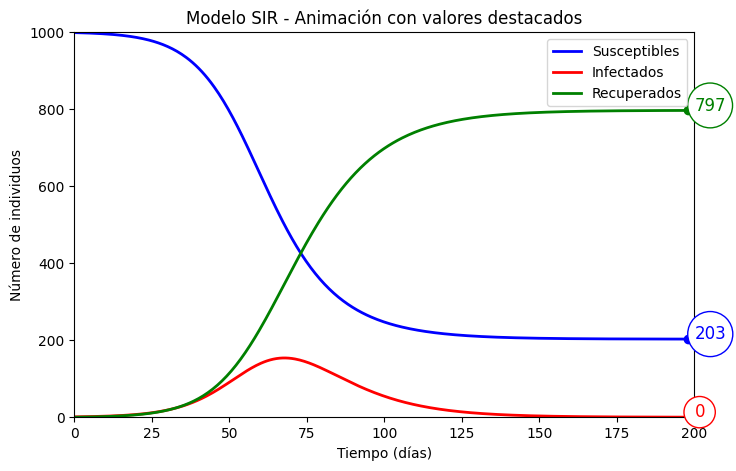

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(0, t_max)
ax.set_ylim(0, N)
ax.set_xlabel("Tiempo (días)")
ax.set_ylabel("Número de individuos")
ax.set_title("Modelo SIR - Animación con valores destacados")

lineS, = ax.plot([], [], 'b-', lw=2, label="Susceptibles")
lineI, = ax.plot([], [], 'r-', lw=2, label="Infectados")
lineR, = ax.plot([], [], 'g-', lw=2, label="Recuperados")
ax.legend()

# Puntos en la punta de cada curva
pointS, = ax.plot([], [], 'bo')
pointI, = ax.plot([], [], 'ro')
pointR, = ax.plot([], [], 'go')

# Textos dinámicos con estilo (más grandes y con círculo)
textS = ax.text(0,0,'',color='blue', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='blue', boxstyle='circle,pad=0.4'))
textI = ax.text(0,0,'',color='red', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='red', boxstyle='circle,pad=0.4'))
textR = ax.text(0,0,'',color='green', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='green', boxstyle='circle,pad=0.4'))

def init():
    lineS.set_data([], [])
    lineI.set_data([], [])
    lineR.set_data([], [])
    pointS.set_data([], [])
    pointI.set_data([], [])
    pointR.set_data([], [])
    textS.set_text('')
    textI.set_text('')
    textR.set_text('')
    return lineS, lineI, lineR, pointS, pointI, pointR, textS, textI, textR

def update(frame):

    idx = frame * step
    if idx >= len(t):
        idx = len(t)-1
    
    # Actualizar curvas
    lineS.set_data(t[:idx], S[:idx])
    lineI.set_data(t[:idx], I[:idx])
    lineR.set_data(t[:idx], R[:idx])
    
    # Actualizar puntos
    pointS.set_data([t[idx]], [S[idx]])
    pointI.set_data([t[idx]], [I[idx]])
    pointR.set_data([t[idx]], [R[idx]])
    
    # Actualizar textos (desplazados a la derecha)
    textS.set_position((t[idx]+2, S[idx]))
    textS.set_text(f"{S[idx]:.0f}")
    textI.set_position((t[idx]+2, I[idx]))
    textI.set_text(f"{I[idx]:.0f}")
    textR.set_position((t[idx]+2, R[idx]))
    textR.set_text(f"{R[idx]:.0f}")
    
    return lineS, lineI, lineR, pointS, pointI, pointR, textS, textI, textR

ani = FuncAnimation(fig, update, frames=len(t)//step, init_func=init,
                    blit=True, interval=100, repeat=False)

HTML(ani.to_jshtml())


# Conclusiones

- La curva azul ($S$) muestra cómo disminuyen los susceptibles.  
- La curva roja ($I$) muestra el número de infectados, que sube, alcanza un máximo y luego baja.  
- La curva verde ($R$) muestra los recuperados, que siempre crecen.  

El texto dinámico en la animación muestra los parámetros del modelo:
- Población total $N$  
- Tasa de transmisión $\beta$  
- Tasa de recuperación $\gamma$  
- Duración promedio de la infección $D$  
- Número reproductivo básico $R_0 = \frac{\beta}{\gamma}$  

Este modelo permite entender cómo evoluciona una epidemia y cómo los parámetros afectan su dinámica.
